In [1]:
import scipy.io as sio
import numpy as np
import mat73
import center_algorithms as ca
import matplotlib.pyplot as plt
import k_means as km
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS


In [2]:

def run_test(gr_list,n_its,seed):
    '''
    calculates Flag Mean, Maximum Cosine and Sine Median for a dataset

    Inputs:

    Outputs:

    '''
    
    k = 48
    
    
    flagmean = ca.flag_mean(gr_list, k, fast = False)
    print('Flag Mean finished')

    #calculate sine median
    sin_median, s_err = ca.irls_flag(gr_list, k, n_its, 'sine', opt_err = 'sine', fast = False, seed = seed)
    print('Sine Median finished')
    
#     #for debugging
#     plt.figure()
#     plt.plot(s_err)
#     plt.title('sine error')

    #calculate maximum cosine
    max_cosine, c_err = ca.irls_flag(gr_list, k, n_its, 'cosine', opt_err = 'cosine', fast = False, seed = seed)
    print('Max Cos finished')
    
#     #for debugging
#     plt.figure()
#     plt.plot(c_err)
#     plt.title('cosine error')
    
    if k==1:
        #calculate geodesic median
        geodesic_median, g_err = ca.irls_flag(gr_list, k, n_its, 'geodesic', opt_err = 'geodesic', fast = False, seed = seed)
        print('Geodesic finished')

        return flagmean, sin_median, max_cosine, geodesic_median, gr_list
    
    else:
        return flagmean, sin_median, max_cosine, gr_list

In [3]:
n_its= 20
seed = 0

labels_raw = sio.loadmat('./data/kmeans_action_labels.mat')['kmeans_action_labels']

labels_true = [l[0][0] for l in labels_raw['labels'][0][0]]
# labelidxs =labels_raw['labelidxs'][0][0][0]


raw_data = mat73.loadmat('./data/kmeans_pts.mat')

gr_list = [t[0] for t in raw_data['Data']['gr_pts']]

print(len(gr_list))
gr_list[0].shape

601


(1024, 48)

In [4]:
label_counts = {}
for l in labels_true:
    label_counts[l] = len(np.where(np.array(labels_true) == l)[0])
label_counts

{'push-cart': 20,
 'clap-group': 41,
 'ride-bike': 17,
 'swing': 3,
 'follow': 32,
 'flap': 11,
 'loiter': 185,
 'bend': 27,
 'run': 24,
 'point-group': 33,
 'cart-motion': 9,
 'stand': 5,
 'pickup': 27,
 'gesture': 39,
 'run-group': 4,
 'walk-rifle': 7,
 'loiter-group': 117}

In [45]:
idx_pushcart = list(np.where(np.array(labels_true) == 'cart-motion')[0])

idx_run = list(np.where(np.array(labels_true) == 'flap')[0])


In [46]:
idx = idx_pushcart + idx_run
all_data = [gr_list[i] for i in idx]
n_all_pts = len(all_data)

Distances = np.zeros((n_all_pts, n_all_pts))

for i in range(n_all_pts):
    for j in range(i+1, n_all_pts):
#         if k == 1:
#             cos = (dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])[0][0]
#             if cos > 1:
#                 cos = 1
#             elif cos < 0:
#                 cos = 0
#             Distances[i,j] = np.arccos(np.sqrt(cos))
#             Distances[j,i] = Distances[i,j].copy()
#         else:
        cos = np.linalg.svd(all_data[i].T @ all_data[j])[1]
        sumcos = np.sum(np.arccos(cos)**2)
        if np.isnan(sumcos):
            sumcos = 0
        Distances[i,j] = np.sqrt(sumcos)
#         Distances[i,j] = np.arccos(np.max(np.linalg.svd(all_data[i].T @ all_data[j])[1]))
#             Distances[i,j] = k - np.trace(dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])
        Distances[j,i] = Distances[i,j].copy()

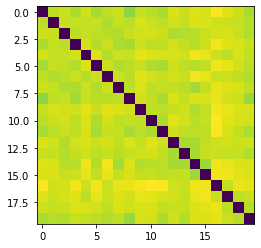

In [47]:
plt.imshow(Distances)

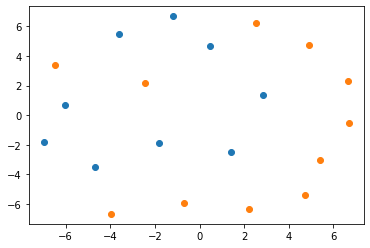

In [48]:
embedding = MDS(dissimilarity = 'precomputed', n_components = 2)
transformed = embedding.fit_transform(Distances)
cut_off = len(idx_pushcart)

plt.figure()
plt.scatter(transformed[:cut_off,0], transformed[:cut_off,1])
plt.scatter(transformed[cut_off:,0], transformed[cut_off:,1])

In [49]:
cut_off, transformed.shape


(9, (20, 2))

In [50]:

flagmeans = []
sin_medians = []
max_cosines = []
geo_medians = []
n_pushcarts  = []
n_runs = []
datasets = []

for i in range(len(idx_run)):
    idx = idx_pushcart + idx_run[:i]
    dataset = [gr_list[ii] for ii in idx]
    out = run_test(dataset,n_its,seed)
    flagmeans.append(out[0])
    sin_medians.append(out[1])
    max_cosines.append(out[2])
#     if k == 1:
#         geo_medians.append(out[3])
    n_pushcarts.append(len(idx_pushcart))
    n_runs.append(i)
# if k == 1:
#     dataset = out[4]
# else:
#     dataset = out[3]
    datasets.append(out[3])

Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished


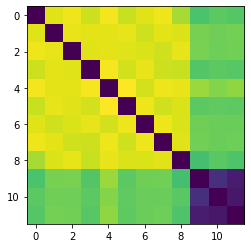

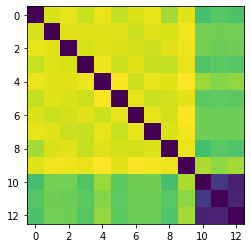

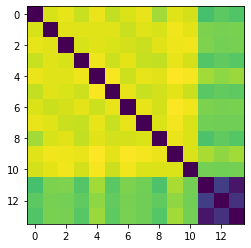

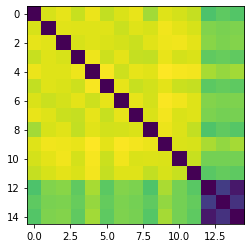

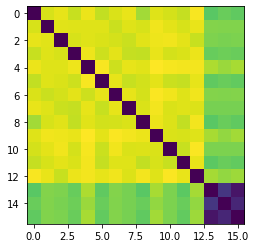

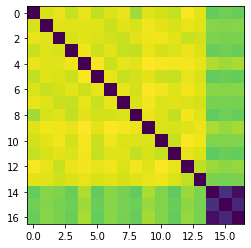

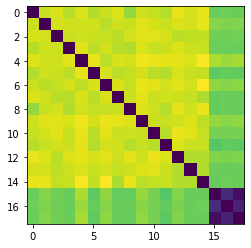

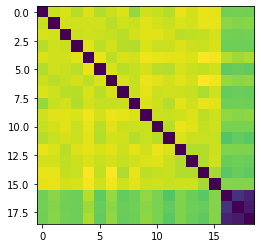

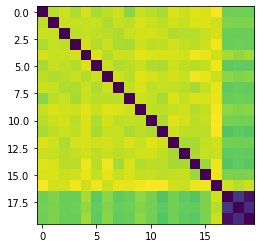

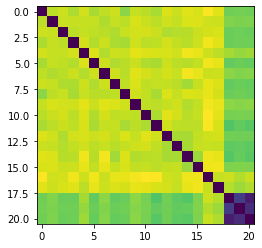

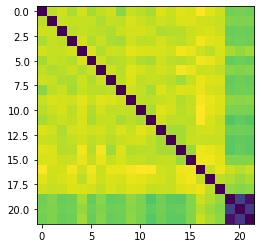

In [51]:
n_pushcart = n_pushcarts[0]
n_run = len(idx_run)
for ii in n_runs:
    dataset_and_averages = datasets[ii] + [sin_medians[ii]]+[max_cosines[ii]]+[flagmeans[ii]]

    n_all_pts = len(dataset_and_averages)

    Distances = np.zeros((n_all_pts, n_all_pts))

    for i in range(n_all_pts):
        for j in range(i+1, n_all_pts):
    #         if k == 1:
    #             cos = (dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])[0][0]
    #             if cos > 1:
    #                 cos = 1
    #             elif cos < 0:
    #                 cos = 0
    #             Distances[i,j] = np.arccos(np.sqrt(cos))
    #             Distances[j,i] = Distances[i,j].copy()
    #         else:
            cos = np.linalg.svd(dataset_and_averages[i].T @ dataset_and_averages[j])[1]
            sumcos = np.sum(np.arccos(cos)**2)
            if np.isnan(sumcos):
                sumcos = 0
            Distances[i,j] = np.sqrt(sumcos)
    #             Distances[i,j] = k - np.trace(dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])
            Distances[j,i] = Distances[i,j].copy()

    plt.figure()
    plt.imshow(Distances)


In [52]:
transformed.shape, n_pushcart, n_runs[-1], 

((20, 2), 9, 10)

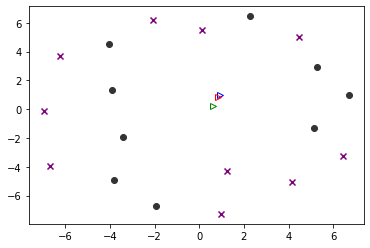

In [53]:
ii=n_runs[-1]
embedding = MDS(dissimilarity = 'precomputed', n_components = 2)
transformed = embedding.fit_transform(Distances)


plt.figure()
plt.scatter(transformed[:n_pushcart,0], transformed[:n_pushcart,1], c = '.2', label = 'Push Cart')
if ii > 0:
    plt.scatter(transformed[n_pushcart:n_pushcart+ii,0], transformed[n_pushcart:n_pushcart+ii,1], color = 'purple', marker = 'x', label = 'Run')
plt.plot(transformed[n_pushcart+ii:n_pushcart+ii+1,0], transformed[n_pushcart+ii:n_pushcart+ii+1,1], c = 'blue', fillstyle = 'none', marker = '>', markevery = 4, label = 'Sine Median')
plt.plot(transformed[n_pushcart+ii+1:n_pushcart+ii+2,0], transformed[n_pushcart+ii+1:n_pushcart+ii+2,1], c = 'green', linestyle = 'dashdot', fillstyle = 'none', marker = '>', markevery = 4, label = 'Maximum Cosine')
plt.plot(transformed[n_pushcart+ii+2:n_pushcart+ii+3,0], transformed[n_pushcart+ii+2:n_pushcart+ii+3,1], c = 'red', linestyle = 'dotted', fillstyle = 'none', marker = '>', markevery = 4, label = 'Flag Mean')




In [54]:
dataset_and_averages = dataset + sin_medians+max_cosines+flagmeans+geo_medians

n_all_pts = len(dataset_and_averages)

Distances = np.zeros((n_all_pts, n_all_pts))

for i in range(n_all_pts):
    for j in range(i+1, n_all_pts):
#         if k == 1:
#             cos = (dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])[0][0]
#             if cos > 1:
#                 cos = 1
#             elif cos < 0:
#                 cos = 0
#             Distances[i,j] = np.arccos(np.sqrt(cos))
#             Distances[j,i] = Distances[i,j].copy()
#         else:
        cos = np.linalg.svd(dataset_and_averages[i].T @ dataset_and_averages[j])[1]
        sumcos = np.sum(np.arccos(cos))
        if np.isnan(sumcos):
            print(cos)
            sumcos = 0
        Distances[i,j] = np.sqrt(sumcos**2)
#             Distances[i,j] = k - np.trace(dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])
        Distances[j,i] = Distances[i,j].copy()

embedding = MDS(dissimilarity = 'precomputed', n_components = 2)
transformed = embedding.fit_transform(Distances)


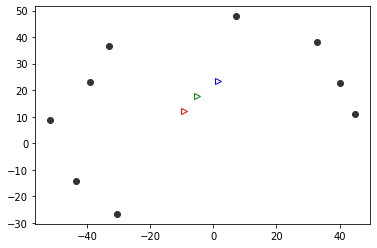

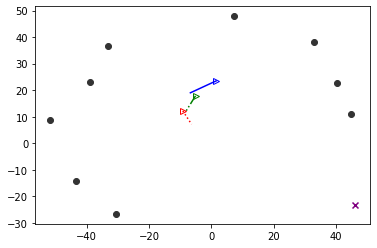

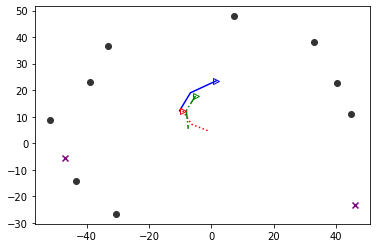

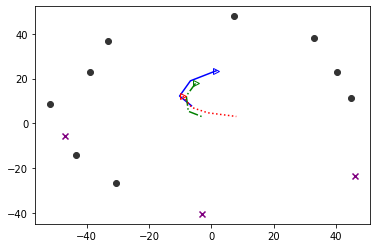

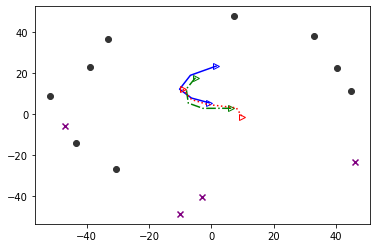

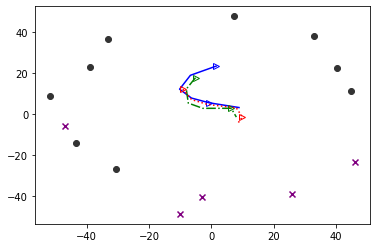

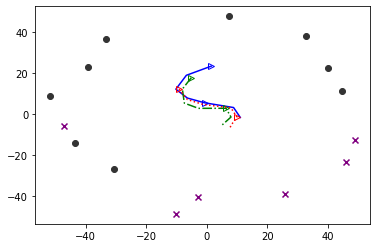

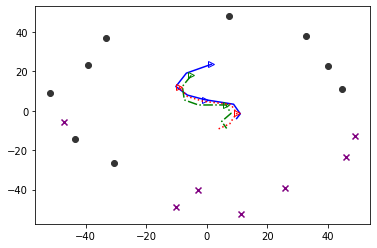

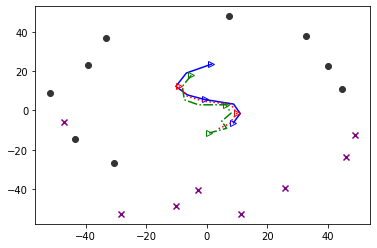

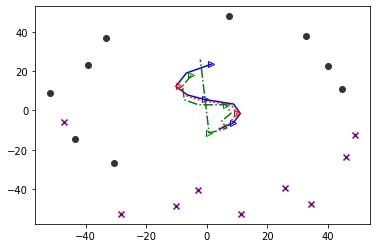

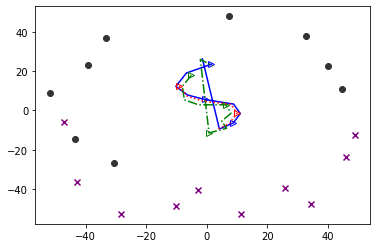

In [55]:
n_pushcart = n_pushcarts[0]
n_run = len(idx_run)
for i in range(0, len(n_runs)):
    plt.figure()
    plt.scatter(transformed[:n_pushcart,0], transformed[:n_pushcart,1], c = '.2', label = 'Push Cart')
    if i > 0:
        plt.scatter(transformed[n_pushcart:n_pushcart+i,0], transformed[n_pushcart:n_pushcart+i,1], color = 'purple', marker = 'x', label = 'Run')
    plt.plot(transformed[n_pushcart+n_run:n_pushcart+n_run+i+1,0], transformed[n_pushcart+n_run:n_pushcart+n_run+i+1,1], c = 'blue', fillstyle = 'none', marker = '>', markevery = 4, label = 'Sine Median')
    plt.plot(transformed[n_pushcart+(n_run+1)*2-1:n_pushcart+(n_run+1)*2-1+i+1,0], transformed[n_pushcart+(n_run+1)*2-1:n_pushcart+(n_run+1)*2-1+i+1,1], c = 'green', linestyle = 'dashdot', fillstyle = 'none', marker = '>', markevery = 4, label = 'Maximum Cosine')
    plt.plot(transformed[n_pushcart+(n_run+1)*3-1:n_pushcart+(n_run+1)*3-1+i+1,0], transformed[n_pushcart+(n_run+1)*3-1:n_pushcart+(n_run+1)*3-1+i+1,1], c = 'red', linestyle = 'dotted', fillstyle = 'none', marker = '>', markevery = 4, label = 'Flag Mean')
#     if k == 1:
#         plt.plot(transformed[num_samples2+(num_samples5+1)*4-1:num_samples2+(num_samples5+1)*4-1+i+1,0], transformed[num_samples2+(num_samples5+1)*4-1:num_samples2+(num_samples5+1)*4-1+i+1,1], c = 'orange', linestyle = 'dashed', fillstyle = 'none', marker = '>', markevery = 4, label = 'Geodesic Median')
#     if i == 8:
#         plt.legend(loc="upper left", bbox_to_anchor=(1,1))